In [1]:
# D604: Advanced Analytics
# Task2: Sentiment Analysis Using Neural Networks

In [2]:
# Import Libraries and Load Dataset
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('task2data_amazon_cells_labelled.txt', sep='\t', header=None, names=['review', 'label'])
print(data.head())
print(f"Total reviews: {len(data)}")
print(f"Label distribution:\n{data['label'].value_counts()}")

                                              review  label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1
Total reviews: 1000
Label distribution:
label
0    500
1    500
Name: count, dtype: int64


Reviews with unusual characters: 250
                                               review unusual_chars
12  If the two were seperated by a mere 5+ ft I st...           [+]
14  The design is very odd, as the ear "clip" is n...        [", "]
20  I went on Motorola's website and followed all ...           [']
23  I have yet to run this new battery below two b...           [']
25               Great Pocket PC / phone combination.           [/]
Vocabulary size: 1879
Mean sequence length: 10.29
95th percentile: 23.049999999999955
Chosen max length: 23


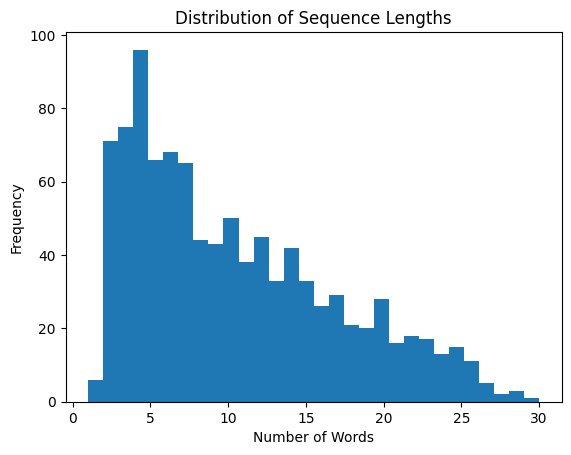

In [3]:
# B1: Exploratory Data Analysis
def has_unusual_chars(text):
    unusual = re.findall(r'[^\w\s.,!?]', text)
    return unusual if unusual else None

data['unusual_chars'] = data['review'].apply(has_unusual_chars)
unusual_reviews = data[data['unusual_chars'].notnull()]
print(f"Reviews with unusual characters: {len(unusual_reviews)}")
print(unusual_reviews[['review', 'unusual_chars']].head())

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

sequences = tokenizer.texts_to_sequences(data['review'])
sequence_lengths = [len(seq) for seq in sequences]

mean_len = np.mean(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)
max_len = int(percentile_95)
print(f"Mean sequence length: {mean_len:.2f}")
print(f"95th percentile: {percentile_95}")
print(f"Chosen max length: {max_len}")

plt.hist(sequence_lengths, bins=30)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [4]:
# B2: Tokenization Process
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

data['review_normalized'] = data['review'].apply(normalize_text)
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['review_normalized'])
sequences = tokenizer.texts_to_sequences(data['review_normalized'])

print("Word Index (sample):", list(tokenizer.word_index.items())[:5])
print("Sample sequence:", sequences[0])

Word Index (sample): [('<OOV>', 1), ('the', 2), ('i', 3), ('it', 4), ('and', 5)]
Sample sequence: [36, 103, 6, 56, 216, 12, 50, 9, 158, 4, 20, 339, 20, 2, 545, 417, 3, 243, 193, 7, 809]


In [5]:
# B3: Padding Process
padded_sequences = pad_sequences(sequences, maxlen=23, padding='pre', truncating='pre')
print("Sample padded sequence (review 0):", padded_sequences[0])

Sample padded sequence (review 0): [  0   0  36 103   6  56 216  12  50   9 158   4  20 339  20   2 545 417
   3 243 193   7 809]


In [6]:
# B4: Number of Sentiment Categories and Activation Function
model = Sequential([
    Embedding(input_dim=1879, output_dim=128),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# B5: Data Preparation Steps - Split into Training, Validation, and Test Sets
X = padded_sequences
y = data['label'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} reviews")
print(f"Validation set: {len(X_val)} reviews")
print(f"Test set: {len(X_test)} reviews")

Training set: 700 reviews
Validation set: 150 reviews
Test set: 150 reviews


In [8]:
# B6: Provide a Copy of the Prepared Dataset - Export to Text File
with open('task2_prepared_dataset.txt', 'w') as f:
    f.write("Training Set (700 reviews):\n")
    for i in range(len(X_train)):
        f.write(f"X_train[{i}]: {X_train[i].tolist()} | y_train[{i}]: {y_train[i]}\n")
    
    f.write("\nValidation Set (150 reviews):\n")
    for i in range(len(X_val)):
        f.write(f"X_val[{i}]: {X_val[i].tolist()} | y_val[{i}]: {y_val[i]}\n")
    
    f.write("\nTest Set (150 reviews):\n")
    for i in range(len(X_test)):
        f.write(f"X_test[{i}]: {X_test[i].tolist()} | y_test[{i}]: {y_test[i]}\n")

print("Prepared dataset saved to 'task2_prepared_dataset.txt'")

Prepared dataset saved to 'task2_prepared_dataset.txt'


In [9]:
# C1: Provide the Output of the Model Summary
model = Sequential([
    Embedding(input_dim=1879, output_dim=128),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model.build(input_shape=(None, 23))  # Build with input shape (batch_size, max_len)
print("\nC1: Model Summary")
model.summary()


C1: Model Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 23, 128)             │         240,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,985 (1.11 MB)

 Trainable params: 289,985 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# C3: Define Hyperparameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Note: Training will occur in Part D, not here
print("\nC3: Hyperparameters Defined")
print("Loss: binary_crossentropy")
print("Optimizer: adam")
print("Stopping Criteria: EarlyStopping with patience=5 on val_loss")


C3: Hyperparameters Defined
Loss: binary_crossentropy
Optimizer: adam
Stopping Criteria: EarlyStopping with patience=5 on val_loss


In [11]:
# D1: Train the Model with Stopping Criteria
print("\nD1: Training the Model")
history = model.fit(X_train, y_train, 
                    epochs=50,  # Max epochs, expecting early stopping to cut it short
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], 
                    verbose=1)

# Get the number of epochs trained
num_epochs = len(history.history['loss'])
print(f"Training stopped after {num_epochs} epochs")


D1: Training the Model
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5480 - loss: 0.6895 - val_accuracy: 0.6467 - val_loss: 0.6751
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7384 - loss: 0.6470 - val_accuracy: 0.6400 - val_loss: 0.6144
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7937 - loss: 0.4645 - val_accuracy: 0.7533 - val_loss: 0.4679
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9342 - loss: 0.2243 - val_accuracy: 0.8133 - val_loss: 0.4475
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9790 - loss: 0.1039 - val_accuracy: 0.8067 - val_loss: 0.7357
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0587 - val_accuracy: 0.8200 - val_loss: 0.5935
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0269 - val_accuracy: 0.8067 - val_loss: 0.7260
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9940 - loss: 0.0210 - val_acc

In [12]:
# E: Save the trained Model
model.save('task2_sentiment_model.keras')
print("Trained model saved as 'task2_sentiment_model.keras'")

Trained model saved as 'task2_sentiment_model.keras'


In [13]:
# D2: Assess Model Fitness Using Accuracy and Loss Metrics
print("\nD2: Model Fitness Assessment")
# Final training and validation metrics from history (last epoch)
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Training Loss: {final_train_loss:.4f}")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

# Test set evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


D2: Model Fitness Assessment
Training Loss: 0.0324
Training Accuracy: 0.9986
Validation Loss: 0.8286
Validation Accuracy: 0.8133
Test Loss: 0.5055
Test Accuracy: 0.7867



D3: Visualizations of Training Process


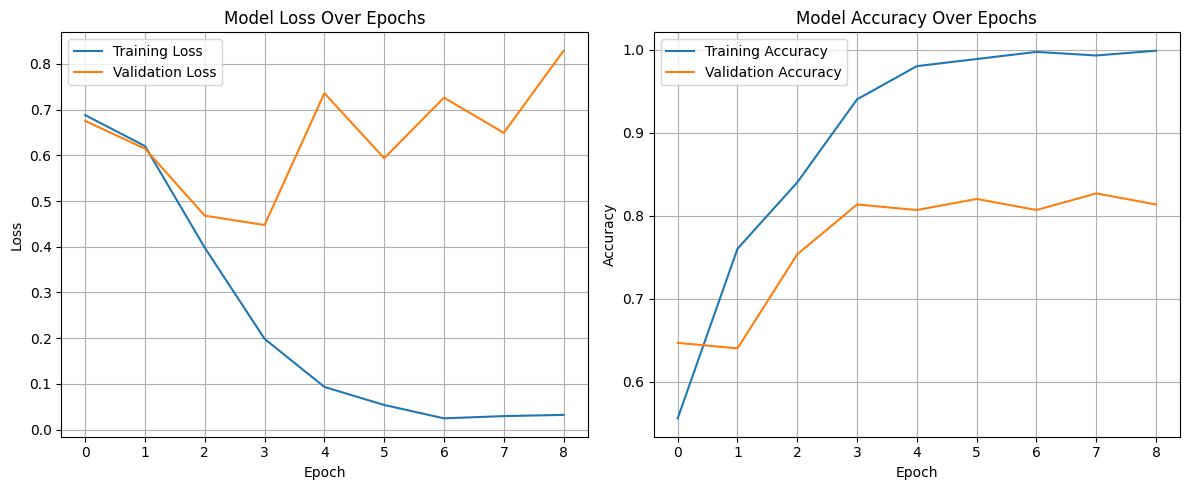

In [14]:
# D3: Visualize Training Process with Loss and Accuracy Metrics
import matplotlib.pyplot as plt

print("\nD3: Visualizations of Training Process")
# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
